In [1]:
%matplotlib widget
from eomaps import Maps, MapsGrid
import numpy as np
import itertools

In [2]:
# setup some random 2D data
lon, lat = np.meshgrid(np.linspace(-180, 180, 200), np.linspace(-90, 90, 100))
data = np.sqrt(lon**2 + lat**2) + np.random.normal(size=lat.shape) ** 2 * 20

name = "some parameter"

D:\python_modules\eomaps\eomaps\eomaps.py:461: UserWarning: EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') when using the 'ipympl' backend to avoid recursions during callbacks!
  "EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') "


EOmaps: estimating radius...
EOmaps: The estimated radius is: 0.9045


'cb_0__single__1'

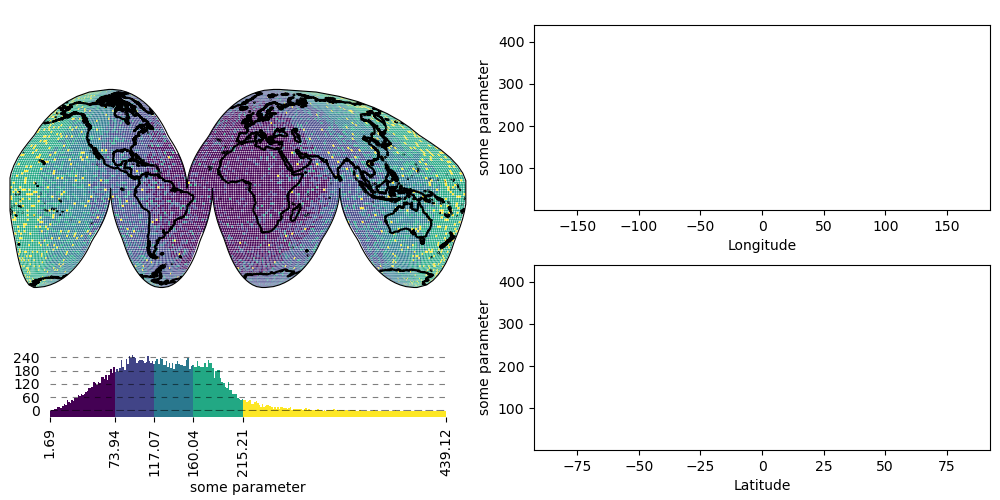

In [3]:
# initialize a map and 2 ordinary plots that will be used to visualize the data
mg = MapsGrid(
    2,
    2,
    m_inits={"map": (slice(0, 2), 0)},
    ax_inits={"row": (0, 1), "col": (1, 1)},
    crs=Maps.CRS.InterruptedGoodeHomolosine(),
    figsize=(10, 5),
)

mg.gridspec.update(top=0.95, bottom=0.1, left=0.01, right=0.99, hspace=0.3, wspace=0.15)

# set the limits and labels for the axes
mg.ax_row.set_xlabel("Longitude")
mg.ax_row.set_ylabel(name)
mg.ax_row.set_xlim(-185, 185)
mg.ax_row.set_ylim(data.min(), data.max())

mg.ax_col.set_xlabel("Latitude")
mg.ax_col.set_ylabel(name)
mg.ax_col.set_xlim(-92.5, 92.5)
mg.ax_col.set_ylim(data.min(), data.max())

# ---- plot the map
m = mg.m_map

m.set_data(data, lon, lat, parameter=name)
m.set_classify_specs(Maps.CLASSIFIERS.NaturalBreaks, k=5)
m.plot_map()
m.add_colorbar(bottom=0.1, top=0)
m.figure.ax_cb.tick_params(rotation=90)
m.add_feature.preset.coastline()

# add some new layers that will be used to indicate rows and columns
m2 = m.new_layer()
m3 = m.new_layer()

# ---- define a custom callback to indicate the clicked row/column
def cb(m, ind, ID, coords, *args, **kwargs):

    # get row and column from the data
    # NOTE: "ind" always represents the index of the flattened array!
    r, c = next(itertools.islice(np.ndindex(m.data.shape), ind, None))
    # update the coordinates in our dictionary
    coords.update(dict(r=r, c=c))

    # ---- highlight the picked column
    m2.set_data(
        m.data_specs.data[:, c], m.data_specs.xcoord[:, c], m.data_specs.ycoord[:, c]
    )
    m2.set_shape.ellipses(m.shape.radius)
    # use "dynamic=True" to avoid re-drawing the background all the time
    # use "set_extent=False" to avoid resetting the plot extent on each draw
    m2.plot_map(fc="none", ec="b", set_extent=False, dynamic=True)
    m.cb.pick.add_temporary_artist(m2.figure.coll)  # remove the highlight on next pick

    # ---- highlight the picked row
    m3.set_data(
        m.data_specs.data[r, :], m.data_specs.xcoord[r, :], m.data_specs.ycoord[r, :]
    )
    m3.set_shape.ellipses(m.shape.radius)
    m3.plot_map(fc="none", ec="r", set_extent=False, dynamic=True)
    m.cb.pick.add_temporary_artist(m3.figure.coll)  # remove the highlight on next pick

    # ---- plot the data for the selected column
    (art0,) = mg.ax_col.plot(m.data_specs.ycoord[:, c], m.data_specs.data[:, c], c="b")
    (art01,) = mg.ax_col.plot(
        m.data_specs.ycoord[r, c],
        m.data_specs.data[r, c],
        c="k",
        marker="o",
        markerfacecolor="none",
        ms=10,
    )

    m.cb.pick.add_temporary_artist(art0)
    m.cb.pick.add_temporary_artist(art01)

    # ---- plot the data for the selected row
    (art1,) = mg.ax_row.plot(m.data_specs.xcoord[r, :], m.data_specs.data[r, :], c="r")
    (art11,) = mg.ax_row.plot(
        m.data_specs.xcoord[r, c],
        m.data_specs.data[r, c],
        c="k",
        marker="o",
        markerfacecolor="none",
        ms=10,
    )
    m.cb.pick.add_temporary_artist(art1)
    m.cb.pick.add_temporary_artist(art11)

    # ---- add a temporary pick-annotation
    # NOTE: *args, **kwargs must be forwarded to the additional callback!
    m.cb.pick._cb.annotate(
        ID=ID,
        text=(
            f"row/col={r}/{c}\n"
            + f"lon/lat={m.data_specs.xcoord[r,c]:.2f}/{m.data_specs.ycoord[r,c]:.2f}"
            + f"\nval={m.data[r,c]:.2f}"
        ),
        permanent=False,
        *args,
        **kwargs,
    )


# initialize a dict that can be used to access the last clicked (row, col)
coords = dict(r=None, c=None)
# attach the custom callback
m.cb.pick.attach(cb, coords=coords)